In [1]:
%matplotlib inline

# Generates scatter plot of Bering Strait Transport and Regional winds for Figure 06 of Bering Strait eat Flux paper

Regional winds are calculated on the fly

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pandas as pd
import os

from affine import Affine
from scipy import stats

import cartopy.crs as ccrs

import sys
sys.path.append('../source')

from constants import MOORING_DIRPATH, REANALYSIS_DIRPATH

/home/apbarret/anaconda3/envs/seaicealbedo_update_dask/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/apbarret/anaconda3/envs/seaicealbedo_update_dask/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [20]:
def read_beringstrait():
    '''
    Returns pandas data frame of Bering Strait heat flux'''
    fili = r'BeringStrait_Monthlymeans_TRANSPORT_Oct2017.txt'
    
    df = pd.read_csv(os.path.join(MOORING_DIRPATH, 'Month', fili), header=None, comment='%',sep='\s+', #skiprows=55,
                     names=['Mooring', 'Year', 'Month', 'Mean', 'Error', 'MeanCorr', 'CorrErr'],
                     parse_dates={'date': ['Year', 'Month']}, index_col='date')
    return df['MeanCorr']


def cosine_weight(da):
    '''
    Calculates a grid of cosine weights to calculate area weighted average
    '''
    dim = da.shape[1:]
    weight = xr.DataArray(np.ones(np.array(dim).prod()).reshape(dim), 
                           coords=da[0,:,:].coords, dims=da[0,:,:].dims)
    weight = weight * np.cos(np.radians(da['lat']))
    weight = weight / weight.sum()
    
    return weight


def area_weighted_average(da):
    '''
    Calculates an area weighted average for a grid
    '''
    weight = cosine_weight(da)
    return (da*weight).sum(dim=['lat','lon'])


def lonFlip(da):
    '''
    Converts longitude coordinates from 0 to 360 to -180 to 180
    or from -180 to 180.  Similar to NCL lonFlip routine
    '''
    
    if da.lon.min() < 0.:
        daNew = da.assign_coords(lon=(da.lon + 360.) % 360.)
    else:
        daNew = da.assign_coords(lon=( ( (da.lon + 180.) % 360. ) - 180. ) )
    
    return daNew.sortby(daNew.lon)


def limits(region):
    """
    Returns lat0, lat1, lon0, lon1 for ocean regions
    """
    
    reg_limits = {
        'bering_strait': {'lat0': 65., 'lat1': 67., 'lon0': 190., 'lon1': 192.},
        'east_siberian_sea': {'lat0': 75., 'lat1': 80., 'lon0': 140., 'lon1': 180.},
        'bering_sea_shelf': {'lat0': 56., 'lat1': 63., 'lon0': 185., 'lon1': 195.},
        'gulf_of_alaska': {'lat0': 52., 'lat1': 58., 'lon0': 200., 'lon1': 220.},
        }
    
    return tuple(reg_limits[region].values())


def get_regional_wind(u, v, region, rotation=0., wind='v'):
    """
    returns regional mean wind rotated to a given direction
    """
    
    # Get limits for ocean region
    lat0, lat1, lon0, lon1 = limits(region)
    
    # Subset region
    usub = u.sel(lat=slice(lat0,lat1),lon=slice(lon0,lon1))
    vsub = v.sel(lat=slice(lat0,lat1),lon=slice(lon0,lon1))
    
    if rotation != 0.:
        urot, vrot = (usub, vsub) * Affine.rotation(rotation)
    else:
        urot, vrot = usub, vsub
    
    if wind == 'u':
        regional_wind = area_weighted_average(urot).to_series()
    else:
        regional_wind = area_weighted_average(vrot).to_series()
    regional_wind.name = '{:s}_{:06.1f}'.format(region,rotation)
    
    return regional_wind


def plot_panel(df, ax, x, y, season, hidex=False, hidey=False, xmin=-10., xmax=5., ymin=-0.5, ymax=2.5, grid=False,
               ylabel='Transport (Sv)', markersize=10, xlabel_fontsize=12, ylabel_fontsize=12):
    
    ssnDict = {'DJF': [12,1,2],
               'MAM': [3,4,5],
               'JJA': [6,7,8],
               'SON': [9,10,11]}

    # get correlation
    xx = df[df.index.month.isin(ssnDict[season])][x]
    yy = df[df.index.month.isin(ssnDict[season])][y]
    corr = stats.pearsonr(xx,yy)

    df[df.index.month.isin(ssnDict[season])].plot.scatter(y=y, x=x, color='0.2', ax=ax, zorder=2, s=markersize)
    
    dfTop = df[df.index.month.isin(ssnDict[season])].sort_values(by='Transport', ascending=False).iloc[:15, :]
    dfTop.plot.scatter(y=y, x=x, color='r', ax=ax, zorder=2, s=markersize)
    
    dfBot = df[df.index.month.isin(ssnDict[season])].sort_values(by='Transport', ascending=True).iloc[:15, :]
    dfBot.plot.scatter(y=y, x=x, color='b', ax=ax, zorder=2, s=markersize)
    
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    
    if hidex:
        ax.set_xlabel('')
        ax.set_xticklabels([])
        ax.set_xticks([])
    else:
        ax.set_xlabel('Wind speed (m/s)', fontsize=xlabel_fontsize)
        ax.set_xticks([-10.,-5.,0.,5])
     
    if hidey:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_yticks([])
    else:
        ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
        ax.set_yticks([-0.5,0.,0.5,1.,1.5,2.])
    
    ax.tick_params(axis='both', labelsize=xlabel_fontsize)
    
    if grid:
        ax.grid(linestyle=':', color='0.6', zorder=1)
        ax.axvline(0., linestyle='-', color='0.3', zorder=1)
        ax.axhline(0., linestyle='-', color='0.3', zorder=1)

    # Make plot square
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    # Add correlation and P-value
    #print (r'$\rho = {:5.2f} ({:4.2f})$'.format(corr[0], corr[1]))
    t = ax.text(0.05, 0.99, r'$r = {:5.2f}\,({:4.2f})$'.format(corr[0], corr[1]), 
            fontsize=12, verticalalignment='top', horizontalalignment='left', 
            transform = ax.transAxes)
    t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='white', boxstyle='square,pad=0'))
    #ax.text(0.05, 0.95, 'ABC') #'$\rho = {:5.2f} ({:4.2f})$'.format(corr[0], corr[1]), transform = ax.transAxes)
    
    #ax.set_title(season+" "+x, fontsize=10)


# Get Data

## Get ocean mask

In [4]:
maskDs = xr.open_dataset(os.path.join(REANALYSIS_DIRPATH, 'CONSTANT', "MERRA2_101.const_2d_asm_Nx.00000000.nc4"))
ocean = lonFlip(maskDs['FROCEAN'])
oceanMask = xr.where(ocean > .8, 1., 0.).squeeze()
#oceanMask

## Get U and V winds

In [5]:
#filePath = r'C:\Users\apbarret\Documents\data\BeringStraitHeatFlux\MERRA2_400.instM_2d_asm_Nx.V10M.month.1980to2018.nc4'
ds = xr.open_dataset(os.path.join(REANALYSIS_DIRPATH, 'V10M', 'MERRA2_400.instM_2d_asm_Nx.V10M.month.1980to2018.nc4'))
v10m = ds['V10M']

#filePath = r'C:\Users\apbarret\Documents\data\BeringStraitHeatFlux\MERRA2_400.instM_2d_asm_Nx.U10M.month.1980to2018.nc4'
ds = xr.open_dataset(os.path.join(REANALYSIS_DIRPATH, 'U10M', 'MERRA2_400.instM_2d_asm_Nx.U10M.month.1980to2018.nc4'))
u10m = ds['U10M']

# Convert longitudes to 0 to 360 range from -180 to 180
uda = lonFlip(u10m)
vda = lonFlip(v10m)

# Apply ocean mask
vda = vda.where(oceanMask == 1)
uda = uda.where(oceanMask == 1)

## Get Bering Strait volume transport

In [6]:
transport = read_beringstrait()
transport.dropna(inplace=True) # Get rid of NaNs
transport.name = 'Transport'

## Generate non-rotated regional winds

In [7]:
df_raw = pd.DataFrame({'Transport': transport, 
                  'Bering Strait': get_regional_wind(uda, vda, rotation=0., wind='v', region='bering_strait'), 
                  'East Siberian Shelf': get_regional_wind(uda, vda, rotation=0., wind='u', region='east_siberian_sea'),
                  'Bering Sea Shelf': get_regional_wind(uda, vda, rotation=0., wind='v', region='bering_sea_shelf'),
                  'Gulf of Alaska': get_regional_wind(uda, vda, rotation=0., wind='u', region='gulf_of_alaska')})
df_raw.dropna(axis=0, inplace=True)
df_raw.head()

,Transport,Bering Strait,East Siberian Shelf,Bering Sea Shelf,Gulf of Alaska
1990-09-01,0.60,-2.074322,0.173427,-1.894294,2.313968
1990-10-01,0.62,-2.476147,0.121908,-1.621198,5.613164
1990-11-01,1.09,-0.523820,-2.422360,-0.220743,5.392169
1990-12-01,0.98,-3.256946,-0.357753,-0.749112,3.132715
1991-01-01,0.51,-4.949245,1.576653,-3.347468,-2.555487


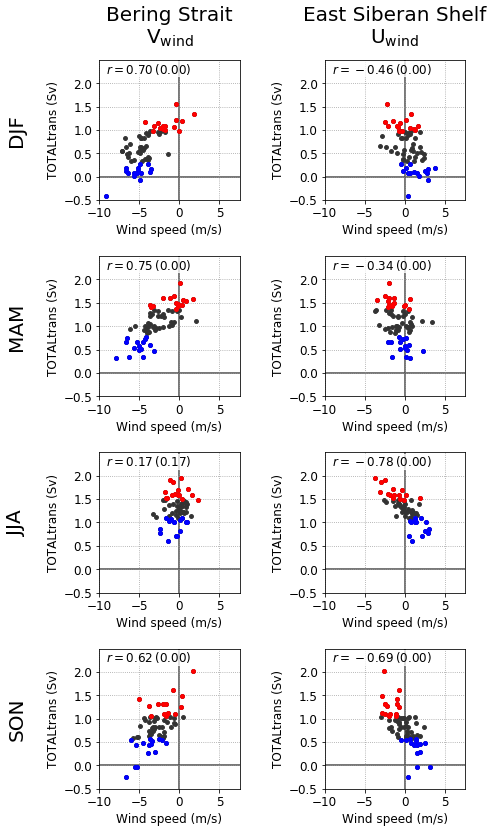

In [21]:
scale = 1.5
markersize=15

fig, ax = plt.subplots(4, 2, figsize=(scale*5.1,scale*10), gridspec_kw = {'wspace':0.2, 'hspace':0.4, 'top': 0.8, 'right':.95, 'left': 0.2})

plot_panel(df_raw, ax[0,0], 'Bering Strait', 'Transport', 'DJF', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)', markersize=markersize)
plot_panel(df_raw, ax[0,1], 'East Siberian Shelf', 'Transport', 'DJF', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)', markersize=markersize)

plot_panel(df_raw, ax[1,0], 'Bering Strait', 'Transport', 'MAM', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)', markersize=markersize)
plot_panel(df_raw, ax[1,1], 'East Siberian Shelf', 'Transport', 'MAM', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)', markersize=markersize)

plot_panel(df_raw, ax[2,0], 'Bering Strait', 'Transport', 'JJA', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)', markersize=markersize)
plot_panel(df_raw, ax[2,1], 'East Siberian Shelf', 'Transport', 'JJA', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)', markersize=markersize)

plot_panel(df_raw, ax[3,0], 'Bering Strait', 'Transport', 'SON', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)', markersize=markersize)
plot_panel(df_raw, ax[3,1], 'East Siberian Shelf', 'Transport', 'SON', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)', markersize=markersize)
#ax[3,1].yaxis.tick_right()
#ax[3,1].yaxis.set_label_position('right')

# Add text
fontsize=20
p0 = ax[0,0].get_position()
fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, 'Bering Strait\n'+r'$\mathregular{V_{wind}}$', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)
p0 = ax[0,1].get_position()
fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, 'East Siberan Shelf\n'+r'$\mathregular{U_{wind}}$', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)

p0 = ax[0,0].get_position()
fig.text(p0.x0-0.15, p0.y0+0.5*p0.height, 'DJF', 
         horizontalalignment='center', verticalalignment='center', fontsize=fontsize, rotation='vertical')
p0 = ax[1,0].get_position()
fig.text(p0.x0-0.15, p0.y0+0.5*p0.height, 'MAM', 
         horizontalalignment='center', verticalalignment='center', fontsize=fontsize, rotation='vertical')
p0 = ax[2,0].get_position()
fig.text(p0.x0-0.15, p0.y0+0.5*p0.height, 'JJA', 
         horizontalalignment='center', verticalalignment='center', fontsize=fontsize, rotation='vertical')
p0 = ax[3,0].get_position()
fig.text(p0.x0-0.15, p0.y0+0.5*p0.height, 'SON', 
         horizontalalignment='center', verticalalignment='center', fontsize=fontsize, rotation='vertical')

fig.savefig('transport_vs_regional_wind_raw_for_pub.png')